In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import gym
import os
from torch.nn import functional as F

In [2]:
from torch.utils.tensorboard import SummaryWriter

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
class RolloutVaeDataset(torch.utils.data.Dataset):
    def __init__(self, dir_path, transform=None):
        super(RolloutVaeDataset, self).__init__()

        self.transform = transform

        self.data = []
        if (dir_path[-1] != '/'):
            dir_path += '/'
        for file in os.listdir(dir_path):
          file_np = np.load(dir_path + str(file))
          imgs = file_np['obs'] # 1000 x 64 x 64 x 3
          for curr_img in imgs:
            self.data.append(curr_img)
            #self.data.append((np.transpose(curr_img, (2, 0, 1))))

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        # TODO
        if (self.transform):
          return self.transform(self.data[idx])
        else:
          return torch.tensor(self.data[idx])

In [5]:
class VAE(nn.Module):
    def __init__(self, device, batch_size=250):
        super(VAE, self).__init__()

        self.device = device
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2),
            nn.ReLU()
        )
        
        self.mufc = nn.Linear(1024, 32)
        self.logvarfc = nn.Linear(1024, 32)
        self.logspikefc = nn.Linear(1024, 32)
        
        self.decoder_fc = nn.Linear(32, 1024)
        
        #self.decoder = nn.Sequential(
        #    nn.ConvTranspose2d(1024, 128, 5, stride=2),
        #    nn.ReLU(),
        #    nn.ConvTranspose2d(128, 64, 5, stride=2),
        #    nn.ReLU(),
        #    nn.ConvTranspose2d(64, 32, 6, stride=2),
        #    nn.ReLU(),
        #    nn.ConvTranspose2d(32, 3, 6, stride=2),
        #    nn.Sigmoid(),
        #)
        self.conv1 = nn.ConvTranspose2d(1024, 128, 5, stride=2)
        self.relu = nn.ReLU()
        self.conv2 = nn.ConvTranspose2d(128, 64, 5, stride=2)
        self.conv3 = nn.ConvTranspose2d(64, 32, 6, stride=2)
        self.conv4 = nn.ConvTranspose2d(32, 3, 6, stride=2)
        self.sig = nn.Sigmoid()
        
        self.batch_size = batch_size

        self.c = torch.tensor([50.0]).to(self.device)
        self.alpha = torch.tensor([0.5]).to(self.device)
        self.beta = torch.tensor([0.1]).to(self.device)

    def decoder(self, z):
      x = self.conv1(z)
      x = self.relu(x)
      x = self.conv2(x)
      x = self.relu(x)
      x = self.conv3(x)
      x = self.relu(x)
      x = self.conv4(x)
      return self.sig(x)
    
    def decoder_parts(self, z, chosen_layer=1):
      x = self.decoder_fc(z)
      x = x.reshape(-1, 1024, 1, 1)
      if (chosen_layer >= 1):
        x = self.conv1(x)
        x = self.relu(x)
      if (chosen_layer >= 2):
        x = self.conv2(x)
        x = self.relu(x)
      if (chosen_layer >= 3):
        x = self.conv3(x)
        x = self.relu(x)
      if (chosen_layer >= 4):
        x = self.conv4(x)
        return self.sig(x)
      else:
        return x
    
    def decoder_layer0(self, z):
      return self.decoder_fc(z)

    def reparameterize(self, mu, logvar, logspike):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std).to(self.device)
        gaussian = eps.mul(std).add_(mu)
        eta = torch.rand_like(std).to(self.device)
        selection = F.sigmoid(self.c*(eta + logspike.exp() - 1))
        return selection.mul(gaussian)
    
    def forward(self, x):
        x = self.encoder(x)
        x = x.reshape(-1, 1024)
        mu, logvar, logspike = self.mufc(x), self.logvarfc(x), -F.relu(-self.logspikefc(x))
        z = self.reparameterize(mu, logvar, logspike)
        z_ = self.decoder_fc(z)
        z_ = z_.reshape(-1, 1024, 1, 1)
        return self.decoder(z_.float()), mu, logvar, logspike
    
    def get_z(self, x):
      with torch.no_grad():
        encoded = self.encoder(x).reshape(-1, 1024)
        mu, logvar, logspike = self.mufc(encoded), self.logvarfc(encoded), -F.relu(-self.logspikefc(encoded))
        return self.reparameterize(mu, logvar, logspike)

    def reconstruct(self, z):
      with torch.no_grad():
        z_ = self.decoder_fc(z)
        z_ = z_.reshape(-1, 1024, 1, 1)
        return self.decoder(z_.float())

    def loss_func(self, x, recon_x, mu, logvar, logspike):
        # Reconstruction term sum (mean?) per batch
        BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

        # see Appendix B from VSC paper / Formula 6
        #spike = torch.clamp(logspike.exp(), 1e-6, 1.0 - 1e-6) 
        #PRIOR = -0.5 * torch.sum(spike.mul(1 + logvar - mu.pow(2) \
          #                                 - logvar.exp())) + \
        #               torch.sum((1 - spike).mul(torch.log((1 - spike) \
         #                                       /(1 - self.alpha))) + \
           #            spike.mul(torch.log(spike/self.alpha)))
        #return BCE + PRIOR
        # see Appendix B from VSC paper / Formula 6
        spike = torch.clamp(logspike.exp(), 1e-6, 1.0 - 1e-6) 

        prior1 = -0.5 * torch.sum(spike.mul(1 + logvar - mu.pow(2) - logvar.exp()))
        prior21 = (1 - spike).mul(torch.log((1 - spike) / (1 - self.alpha)))
        prior22 = spike.mul(torch.log(spike / self.alpha))
        prior2 = torch.sum(prior21 + prior22)
        PRIOR = prior1 + prior2

        return BCE + self.beta * PRIOR

    def update(self):
      self.c += 0.001

In [6]:
def initialize_weights(layer):
    with torch.no_grad():
        if type(layer) == nn.Linear:
            torch.nn.init.xavier_normal_(layer.weight)
            layer.bias.data.fill_(0.01)
        if type(layer) == nn.Conv2d:
            torch.nn.init.xavier_normal_(layer.weight)
            layer.bias.data.fill_(0.01)
        if type(layer) == nn.ConvTranspose2d:
            torch.nn.init.xavier_normal_(layer.weight)
            layer.bias.data.fill_(0.01)

In [7]:
#!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp36-cp36m-linux_x86_64.whl
#import torch_xla
#import torch_xla.core.xla_model as xm

In [8]:
#device = xm.xla_device()

In [9]:
LR1 = 1e-3
LR2 = 1e-4
LR3 = 1e-5
BATCH_SIZE = 1000
USE_CUDA = True
BETAS = (0.9, 0.999) # default adam betas
NUM_EPOCHS = 10

use_cuda = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
NUM_WORKERS = multiprocessing.cpu_count()
print('num workers:', NUM_WORKERS)

Using device cuda
num workers: 2


In [10]:
path = '/content/drive/MyDrive/env_rollouts/'
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize(mean=(0,), std=(1,))])
data_train = RolloutVaeDataset(path, transforms)
trainloader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,shuffle=True)

vae = VAE(device, batch_size=BATCH_SIZE)
vae.to(device)

optim = torch.optim.Adam(vae.parameters(), lr=LR1)
vae.apply(initialize_weights) 
train_losses = []

In [11]:
def train(vae, num_epochs, optimizer, train_losses, device):
  for epoch in range(NUM_EPOCHS):
      print('epoch: ' + str(epoch))

      epoch_losses = []
      for i, data in enumerate(trainloader, 0):
          X_batch = data.to(device, dtype=torch.float)
          X_prime, mu, logvar, logspike = vae(X_batch)
          loss = vae.loss_func(X_batch, X_prime, mu, logvar, logspike)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          vae.update()
          epoch_losses.append(loss.item())

      epoch_loss = np.mean(epoch_losses)
      print('epoch loss: ' + str(epoch_loss))
      train_losses.append(epoch_loss)

In [12]:
train(vae, 10, optim, train_losses, device)

epoch: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch loss: 7911478.791666667
epoch: 1
epoch loss: 7583037.577380952
epoch: 2
epoch loss: 7423346.833333333
epoch: 3
epoch loss: 7394912.666666667
epoch: 4
epoch loss: 7383970.505952381
epoch: 5
epoch loss: 7376754.369047619
epoch: 6
epoch loss: 7372187.107142857
epoch: 7
epoch loss: 7366577.31547619
epoch: 8
epoch loss: 7362505.392857143
epoch: 9
epoch loss: 7359452.392857143


In [14]:
optim = torch.optim.Adam(vae.parameters(), lr=LR2)
train(vae, 5, optim, train_losses, device)

epoch: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch loss: 7356056.255952381
epoch: 1
epoch loss: 7354623.285714285
epoch: 2
epoch loss: 7353466.005952381
epoch: 3
epoch loss: 7352401.196428572
epoch: 4
epoch loss: 7351351.285714285
epoch: 5
epoch loss: 7350336.482142857
epoch: 6
epoch loss: 7349497.017857143
epoch: 7
epoch loss: 7348638.077380952
epoch: 8
epoch loss: 7347983.94047619
epoch: 9
epoch loss: 7347240.202380952


In [15]:
optim = torch.optim.Adam(vae.parameters(), lr=LR3)
train(vae, 5, optim, train_losses, device)

epoch: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch loss: 7346621.898809524
epoch: 1
epoch loss: 7346484.642857143
epoch: 2
epoch loss: 7346402.505952381
epoch: 3
epoch loss: 7346263.666666667
epoch: 4
epoch loss: 7346157.119047619
epoch: 5
epoch loss: 7346072.363095238
epoch: 6
epoch loss: 7345956.166666667
epoch: 7
epoch loss: 7345871.404761905
epoch: 8
epoch loss: 7345768.029761905
epoch: 9
epoch loss: 7345659.476190476


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


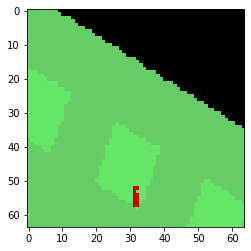

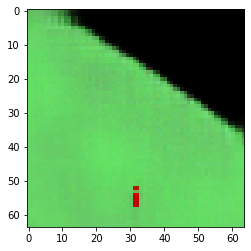

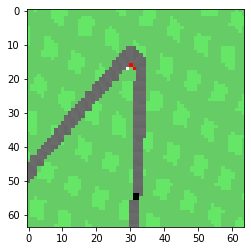

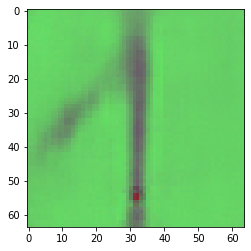

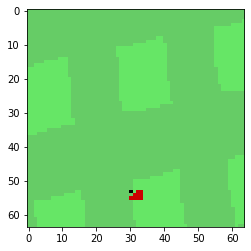

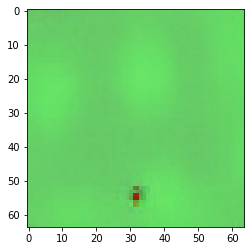

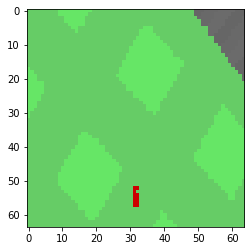

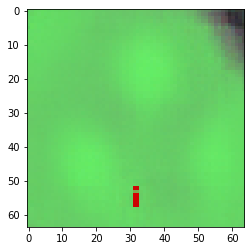

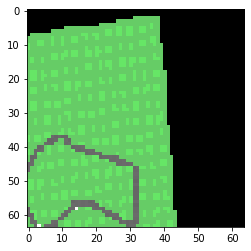

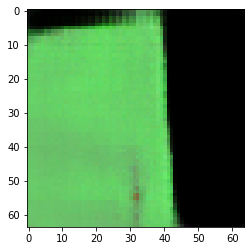

In [ ]:
from PIL import Image
with torch.no_grad():
  for i, data in enumerate(trainloader, 0):
    X_batch = data.to(device, dtype=torch.float)
    X_prime, mu, logvar, logspike = vae(X_batch)
    for i in range(5):
      x_orig = np.transpose(X_batch[i].cpu().numpy(), (1, 2, 0))
      plt.imshow(x_orig)
      plt.show()
      x_recon = np.transpose(X_prime[i].cpu().numpy(), (1, 2, 0))
      plt.imshow(x_recon)
      plt.show()
    break

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


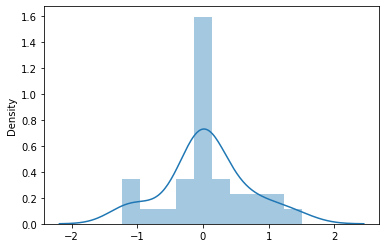

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


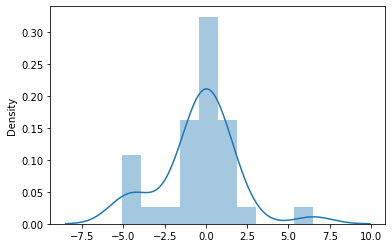

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


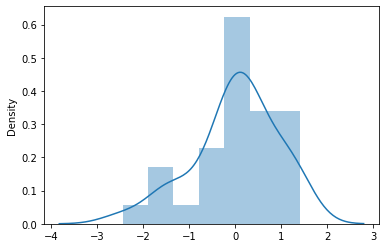

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


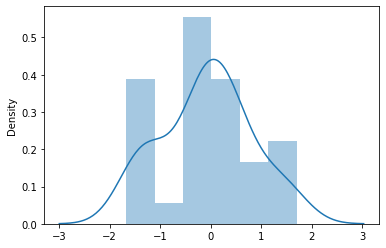

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


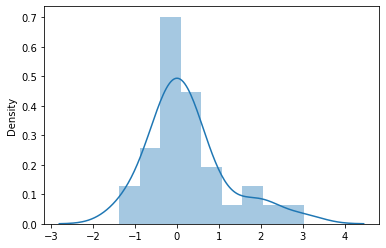

In [ ]:
with torch.no_grad():
  for i, data in enumerate(trainloader, 0):
    X_batch = data.to(device, dtype=torch.float)
    the_zs = vae.get_z(X_batch)
    for i in range(5):
      sns.distplot(the_zs[i].cpu().numpy())
      plt.show()
    break

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


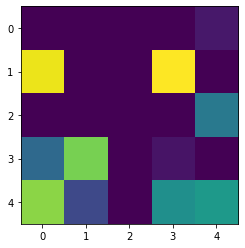

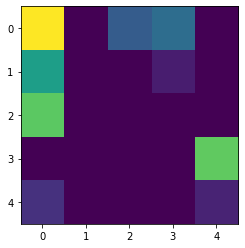

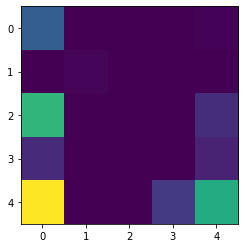

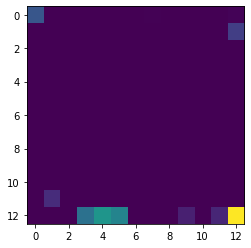

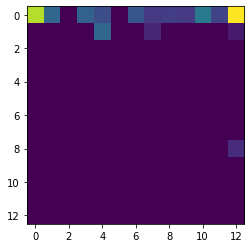

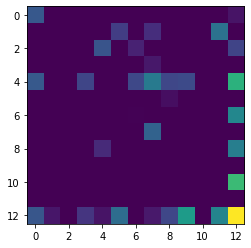

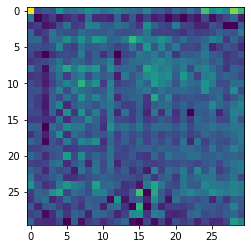

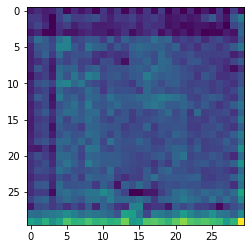

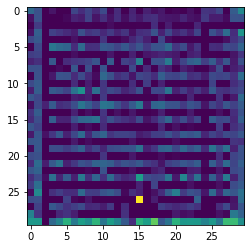

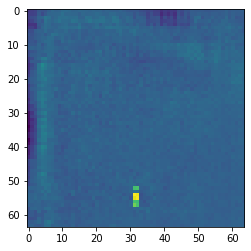

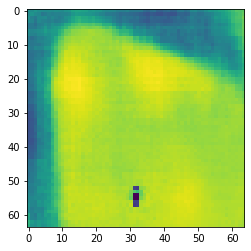

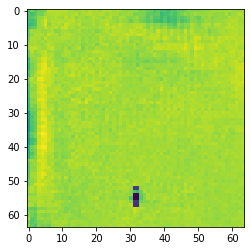

In [ ]:
with torch.no_grad():
  for i, data in enumerate(trainloader, 0):
    X_batch = data.to(device, dtype=torch.float)
    the_zs = vae.get_z(X_batch)
    for i in range(4):
      curr_layer = i + 1
      comp = vae.decoder_parts(the_zs, chosen_layer=curr_layer)
      for j in range(3):
        curr_comp = comp[0][j].cpu().numpy()
        plt.imshow(curr_comp)
        plt.show()
    break

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


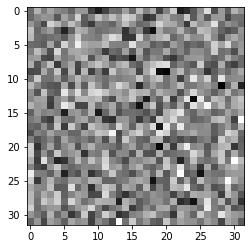

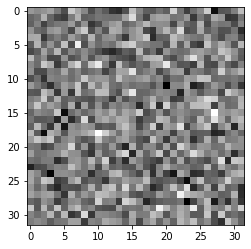

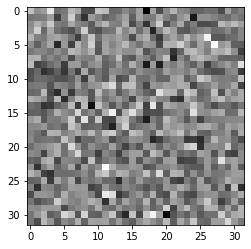

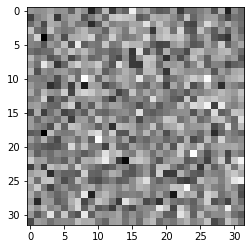

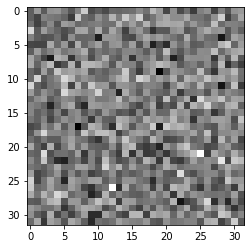

In [ ]:
with torch.no_grad():
  for i, data in enumerate(trainloader, 0):
    X_batch = data.to(device, dtype=torch.float)
    the_zs = vae.get_z(X_batch)
    layer0 = vae.decoder_layer0(the_zs)
    for j in range(5):
      plt.imshow(layer0[j].cpu().numpy().reshape(-1, 32), cmap='gray')
      plt.show()
    break